In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
from keras.datasets import mnist
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, Activation
import keras.backend as K
import keras.losses as losses
from keras.optimizers import Adam,SGD 
import keras.metrics as metrics
from keras.models import Model
from functools import reduce
from operator import mul
from sklearn.model_selection import train_test_split
from ipywidgets import interact
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import ipywidgets as ipy
import matplotlib.pyplot as plt
from keras.layers import LeakyReLU
import numpy as np
%matplotlib inline

/home/qati/.anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]*x_test.shape[2]))

In [4]:
x_train = x_train/255.
x_test  = x_test/255.
np.min(x_train), np.max(x_train)

(0.0, 1.0)

t-SNE output has shape: (10000, 2)


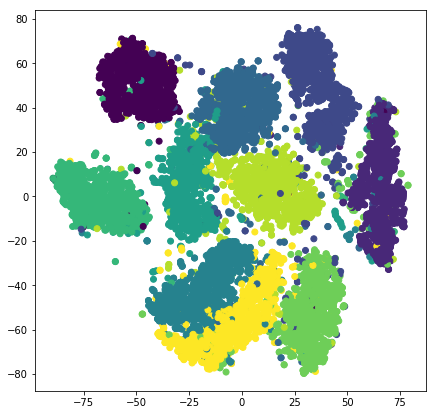

In [5]:
tsne = TSNE(n_components=2, n_iter=1000,  perplexity=30)
tsne_output = tsne.fit_transform(x_test.reshape(x_test.shape[0],28*28))
print('t-SNE output has shape: {}'.format(tsne_output.shape))
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(tsne_output[:,0], tsne_output[:,1],c=y_test)

In [5]:
def build_ae(input_shape, lrelu=0.2, layer_sizes=[512, 256, 128, 64, 32, 16]):
    n = reduce(mul,input_shape,1)
    
    #encoder
    pic = Input(shape=(n,))
    encoded = Dense(n)(pic)
    encoded = LeakyReLU(0.2)(encoded)
    for ls in layer_sizes:
        encoded = Dense(ls)(encoded)
        encoded = LeakyReLU(0.2)(encoded)
    encoder = Model(inputs=[pic], outputs=[encoded])
    
    #decoder
    enc = Input((layer_sizes[-1],))
    decoded = Dense(layer_sizes[-1])(enc)
    decoded = LeakyReLU(0.2)(decoded)
    for ls in reversed(layer_sizes[:-1]):
        decoded = Dense(ls)(decoded)
        decoded = LeakyReLU(0.2)(decoded)
    decoded = Dense(n)(decoded)
    decoded = Activation('sigmoid')(decoded)
    decoder = Model(inputs=[enc], outputs=[decoded])
    
    encoder.summary()
    decoder.summary()

    #autoencoder
    autoencoder = Model(inputs=[pic], outputs=decoder(encoder.output))    
    
    return encoder, decoder, autoencoder

def loss(x,y):
     return losses.binary_crossentropy(K.batch_flatten(x), K.batch_flatten(y))

## 2D latent space

In [6]:
encoder, decoder, autoencoder = build_ae([28,28], lrelu=0.2, layer_sizes=[512,256,128,64,32,16,8,4,2])
autoencoder.compile(loss=loss, optimizer=Adam(0.002))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
__________

In [52]:
history = autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=50, batch_size=512)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.2836 - val_loss: 0.2405
Epoch 2/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.2344 - val_loss: 0.2282
Epoch 3/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.2255 - val_loss: 0.2245
Epoch 4/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.2117 - val_loss: 0.2049
Epoch 5/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.2022 - val_loss: 0.1964
Epoch 6/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.1930 - val_loss: 0.1916
Epoch 7/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.1883 - val_loss: 0.1876
Epoch 8/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.1853 - val_loss: 0.1841
Epoch 9/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.1824 - val_loss: 0.1836
Epoch

In [53]:
#autoencoder.save_weights("ae_simple_mnist_2d_2.h5")

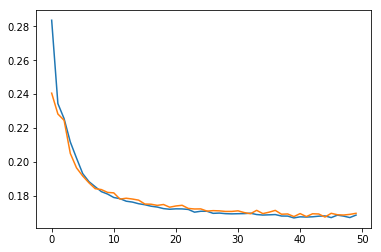

In [54]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [7]:
autoencoder.load_weights("ae_simple_mnist_2d_2.h5")

In [8]:
E_test = encoder.predict(x_test.reshape((x_test.shape[0],28*28)))
D_test = decoder.predict(E_test)
D_test = D_test.reshape((D_test.shape[0],28,28))

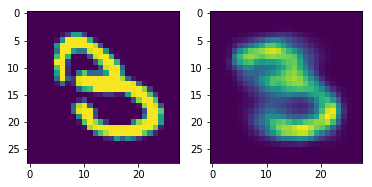

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2)#, sharey=True, sharex=True)
i=18
ax1.imshow(x_test[i].reshape((28,28)))
ax2.imshow(D_test[i,:,:])

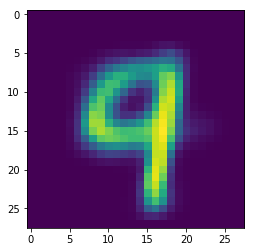

In [58]:
avgenc7 = np.mean(E_test[y_test==7], axis=0)
avgenc7dec = decoder.predict(avgenc7.reshape(1,2))
avgenc7dec = avgenc7dec.reshape((1,28,28))
plt.imshow(avgenc7dec[0,:,:])

In [59]:
enc_of7 = avgenc7
enc_of2 = E_test[3,:]
def plot(x):
    enc = x*enc_of7+(1-x)*enc_of2
    dec = decoder.predict(enc.reshape(1,2))
    dec = dec.reshape((28,28))
    plt.imshow(dec)
    plt.show()
    
interact(plot,x=(-1,1,0.01)) #0.48

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

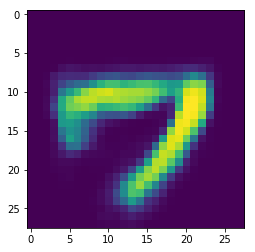

In [67]:
E_rand = np.random.randn(10,2)
D_rand = decoder.predict(E_rand)
D_rand = D_rand.reshape((10,28,28))
plt.imshow(D_rand[3,:,:])

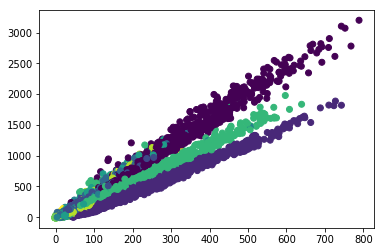

In [68]:
plt.scatter(E_test[:,0], E_test[:,1], c=y_test.astype(np.float))

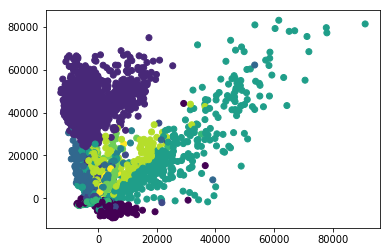

In [13]:
plt.scatter(E_test[:,0], E_test[:,1], c=y_test.astype(np.float))

## 16D latent space

In [11]:
encoder, decoder, autoencoder = build_ae([28,28], 0.2, layer_sizes=[512,256,128,64,32,16])
autoencoder.compile(loss=loss, optimizer=Adam(0.001))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 256)               0         
__________

In [34]:
history = autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=50, batch_size=512)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.2859 - val_loss: 0.2487
Epoch 2/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.2296 - val_loss: 0.2096
Epoch 3/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.1956 - val_loss: 0.1817
Epoch 4/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1662 - val_loss: 0.1571
Epoch 5/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.1518 - val_loss: 0.1464
Epoch 6/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.1436 - val_loss: 0.1402
Epoch 7/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.1380 - val_loss: 0.1348
Epoch 8/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.1331 - val_loss: 0.1315
Epoch 9/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1292 - val_loss: 0.1265
Epoch

In [37]:
#autoencoder.save_weights("ae_simple_mnist_16d_2.h5")

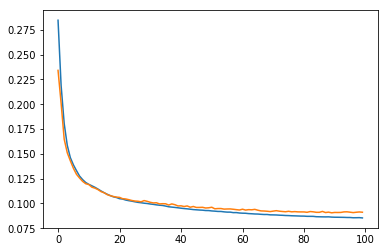

In [47]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [12]:
autoencoder.load_weights("ae_simple_mnist_16d_2.h5")

In [13]:
E_test = encoder.predict(x_test)
D_test = decoder.predict(E_test)
D_test = D_test.reshape((D_test.shape[0],28,28))

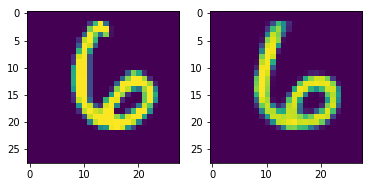

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2)#, sharey=True, sharex=True)
i=88
ax1.imshow(x_test[i].reshape((28,28)))
ax2.imshow(D_test[i,:,:])

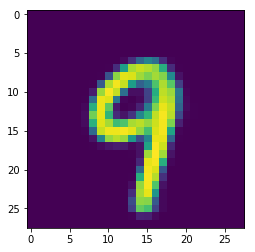

In [41]:
avgenc7    = np.mean(E_test[y_test==9], axis=0)
avgenc7dec = decoder.predict(avgenc7.reshape(1,16))
avgenc7dec = avgenc7dec.reshape((1,28,28))
plt.imshow(avgenc7dec[0,:,:])

In [45]:
enc_of7 = avgenc7
enc_of2 = E_test[3,:]
def plot(x):
    enc = x*enc_of7+(1-x)*enc_of2
    dec = decoder.predict(enc.reshape(1,16))
    dec = dec.reshape((28,28))
    plt.imshow(dec)
    plt.show()
    
interact(plot,x=(-1,1,0.01))

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

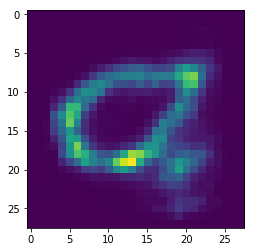

In [46]:
E_rand = np.random.randn(10,16)
D_rand = decoder.predict(E_rand)
D_rand = D_rand.reshape((10,28,28))
plt.imshow(D_rand[6,:,:])

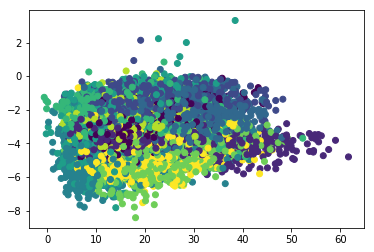

In [49]:
plt.scatter(E_test[:,0], E_test[:,5], c=y_test.astype(np.float))